<a href="https://colab.research.google.com/github/yohanesnuwara/PalmCV/blob/main/Agrari_Detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip "/content/drive/MyDrive/Agrari AI/agrari_v1.v2-version_prelim2.yolov8.zip"

Archive:  /content/drive/MyDrive/Agrari AI/agrari_v1.v2-version_prelim2.yolov8.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
 extracting: data.yaml               
 extracting: test/images/Jeruk-1-3-tahun-barat_jpg.rf.80a0e5960d22295f09b36517bce42b19.jpg  
 extracting: test/images/Jeruk-11-3-tahun-selatan_jpg.rf.5dafd98c416259ac990be91528b0c78a.jpg  
 extracting: test/images/Jeruk-13-3-tahun-selatan_jpg.rf.5e3eedd0220a3013b58fc69e397c02ef.jpg  
 extracting: test/images/Jeruk-13-3-tahun-timur_jpg.rf.9676baa0298d329f9cc107feec7624f3.jpg  
 extracting: test/images/Jeruk-14-3-tahun-barat_jpg.rf.d8ad238d11affdb408d7e475c7dc6372.jpg  
 extracting: test/images/Jeruk-2-4-tahun-selatan_jpg.rf.8987ec8a867084dfa765d4a7e6ac36a6.jpg  
 extracting: test/images/Jeruk-21-3-tahun-selatan_jpg.rf.1aad5f43c725b919b6086d345a0880d0.jpg  
 extracting: test/images/Jeruk-22-3-tahun-barat_jpg.rf.bbde1088c0113e1d

In [26]:
class_names = ['jeruk_kecil', 'pw0_KH', 'pw0_KK', 'pw0_mulus', 'pw100_KH', 'pw100_KK', 'pw100_Sakit', 'pw100_mulus', 'pw25_KH', 'pw25_mulus', 'pw50_KH', 'pw50_mulus', 'pw75_KH', 'pw75_KK', 'pw75_mulus']
class_codes = np.arange(len(class_names))

df_class = pd.DataFrame({"name": class_names, "code": class_codes})

df_class

,name,code
0,jeruk_kecil,0
1,pw0_KH,1
2,pw0_KK,2
3,pw0_mulus,3
4,pw100_KH,4
5,pw100_KK,5
6,pw100_Sakit,6
7,pw100_mulus,7
8,pw25_KH,8
9,pw25_mulus,9


In [29]:
label['name']

0    pw0_mulus
1    pw0_mulus
2    pw0_mulus
3    pw0_mulus
4    pw0_mulus
5    pw0_mulus
6    pw0_mulus
7    pw0_mulus
8    pw0_mulus
Name: name, dtype: object

In [33]:
def crop(image_file, x_center, y_center, width, height):
  image = cv2.imread(image_file)
  image_height, image_width, _ = image.shape
  x_min = int((x_center - width / 2) * image_width)
  y_min = int((y_center - height / 2) * image_height)
  x_max = int((x_center + width / 2) * image_width)
  y_max = int((y_center + height / 2) * image_height)

  # Crop the image
  cropped_image = image[y_min:y_max, x_min:x_max]
  return cropped_image



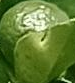

In [71]:
from google.colab.patches import cv2_imshow

cv2_imshow(cropped_image)

In [ ]:
!ls /content/classify/train/pw100_mulus

In [75]:
import glob
import pandas as pd
import numpy as np

for f in glob.glob("/content/valid/labels/*.txt"):
  filename = f.split("/")[-1]
  fileid = (".").join(filename.split(".")[:-1])
  try:
    label = pd.read_csv(f, delimiter=" ", names=["code", "x", "y", "w", "h"])
    # Map class code to class name
    label['name'] = label['code'].map(df_class.set_index('code')['name'])

    for i in range(len(label)):
      label_i = label.iloc[i,:]
      class_id = label_i["name"]
      fileid_label = fileid + "_" + str(i) + ".jpg"
    
    # Image file
    fileid_jpg = fileid + ".jpg"
    image_file = "/content/valid/images/" + fileid_jpg

    
    # Crop image by bounding box
    cropped_image = crop(image_file, label_i["x"], label_i["y"], label_i["w"], label_i["h"])
    
    # Save tiles
    output_crop_filename = "/content/classify/valid/" + class_id + "/" + fileid_label 
    cv2.imwrite(output_crop_filename, cropped_image)

  except:
    label = pd.DataFrame()
  
  # print(fileid)

In [ ]:
im_path = "/content/runs/detect/predict/Jeruk-27-3-tahun-utara_jpg.rf.f7064d8c38df4a98804dc39e7a10b15b.jpg"
im = cv2.imread(im_path)
im.shape

(4000, 2992, 3)

In [2]:
def get_bounding_box(image, label):
  # Returns x0, y0 as bottom left coordinate and x1, y1 as top right coordinate
  img = cv2.imread(image)
  w_img, h_img, ch_img = img.shape

  lab = np.loadtxt(label)

  # Get palm class, center coordinates, width, and height from label data
  pclass, xc, yc, w, h = lab[:,0], lab[:,1], lab[:,2], lab[:,3], lab[:,4]

  # Calculate center coordinates in pixels
  x_lab, y_lab = xc * w_img, yc * h_img

  # Calculate width and height of label in pixels: w relative, h_relative, y, h
  w_lab, h_lab = w * w_img, h * h_img

  # Calculate offset
  x_ofset, y_ofset = w_lab / 2, h_lab / 2

  # Calculate x0, y0
  x0, y0 = (x_lab - x_ofset).astype(int), (y_lab - y_ofset).astype(int)

  # Calculate x1, y1
  x1, y1 = (x0 + w_lab).astype(int), (y0 + h_lab).astype(int)  
  return pclass, x0, y0, x1, y1

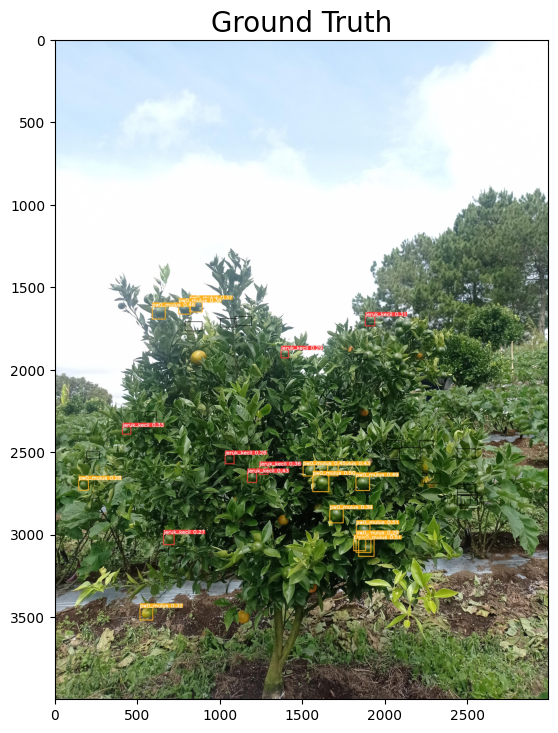

In [7]:
image = '/content/Jeruk-25-3-tahun-selatan_jpg.rf.20409c7b324f9ac0925ad5584534d309.jpg'
label = '/content/Jeruk-25-3-tahun-selatan_jpg.rf.20409c7b324f9ac0925ad5584534d309.txt'

# Get bounding box coordinates (groundtruth)
pclass, x0, y0, x1, y1 = get_bounding_box(image, label)


plt.figure(figsize=(14,14))

# Plot 1: Ground truth
plt.subplot(1,2,1)
img = cv2.imread(image)

for i in range(len(x0)):
  a, b = x0[i], y0[i]+500
  c, d = x1[i], y1[i]+500

  # Plot bounding box
  thickness = 2
  f = cv2.rectangle(img, (a,b), (c,d), color=(0,0,0), thickness=2)
  f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
  
  # Plot image
  plt.imshow(f)
  plt.title('Ground Truth', size=20)

In [ ]:
import math

def yolobbox2bbox(x,y,w,h):
    x1, y1 = x-w/2, y-h/2
    x2, y2 = x+w/2, y+h/2
    return x1, y1, x2, y2

def calculate_object_size(object_length_pixel, object_width_pixel, focal_length, sensor_width, sensor_height, distance):
    
    actual_width = (object_width_pixel*focal_length)/(distance*sensor_width)
    actual_height = (object_length_pixel*focal_length)/(distance*sensor_height)
    
    actual_height_orange = math.sqrt(actual_width**2 + actual_height**2)
    return actual_width, actual_height

# # Parameters
object_width = 43  # pixel
object_height = 9  # pixel
focal_length = 35  # m/pixel
sensor_width = 5.6  # mm
sensor_height = 4.2  # mm
distance = 2 # m

x,y,w,h = 0.304294, 0.574778, 0.0359284, 0.0295322
# 0.320205,0.362305,0.0106235,0.00434094
# 0.105437,0.516622,0.0339967,0.0158977

x1, y1, x2, y2 = yolobbox2bbox(x,y,w,h)

object_height = abs(y2-y1)*4000
object_width = abs(x2-x1)*2992

actual_width, actual_height = calculate_object_size(object_height, object_width, focal_length, sensor_width, sensor_height, distance)

print("Real size: {} mm".format(actual_width))
print("Real size: {} mm".format(actual_height))
print(object_height)

# Print the results
# print("Actual Width: {:.2f} meters".format(actual_width))
# print("Actual Height: {:.2f} meters".format(actual_height))


Real size: 335.9305399999998 mm
Real size: 492.2033333333335 mm
118.12880000000004


In [ ]:
!wget https://zenodo.org/record/7896865/files/epoch35.pt?download=1

--2023-05-08 13:20:20--  https://zenodo.org/record/7896865/files/epoch35.pt?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 349979644 (334M) [application/octet-stream]
Saving to: ‘epoch35.pt?download=1’

epoch35.pt?download 100%[===================>] 333.77M  3.38MB/s    in 5m 4s   

2023-05-08 13:25:27 (1.10 MB/s) - ‘epoch35.pt?download=1’ saved [349979644/349979644]



In [ ]:
!mv "/content/epoch35.pt?download=1" "/content/epoch35.pt"

In [ ]:
# Pip install method (recommended)
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.94 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 24.1/107.7 GB disk)


In [ ]:
# Git clone method (for development)
!git clone https://github.com/ultralytics/ultralytics
%pip install -qe ultralytics

Cloning into 'ultralytics'...
remote: Enumerating objects: 7815, done.
remote: Counting objects: 100% (1419/1419), done.
remote: Compressing objects: 100% (815/815), done.
remote: Total 7815 (delta 818), reused 1011 (delta 584), pack-reused 6396
Receiving objects: 100% (7815/7815), 5.89 MiB | 7.91 MiB/s, done.
Resolving deltas: 100% (5172/5172), done.
  Preparing metadata (setup.py) ... done


In [ ]:
!yolo predict model='/content/epoch35.pt' source='/content/test/images' save_txt=True save=True

Ultralytics YOLOv8.0.94 🚀 Python-3.10.11 torch-2.0.0+cu118 CPU
Model summary (fused): 268 layers, 43618173 parameters, 0 gradients, 164.9 GFLOPs

image 1/19 /content/test/images/Jeruk-1-3-tahun-barat_jpg.rf.80a0e5960d22295f09b36517bce42b19.jpg: 640x320 2 pw0_muluss, 1 pw100_mulus, 1491.2ms
image 2/19 /content/test/images/Jeruk-11-3-tahun-selatan_jpg.rf.5dafd98c416259ac990be91528b0c78a.jpg: 640x320 3 pw0_muluss, 1858.0ms
image 3/19 /content/test/images/Jeruk-13-3-tahun-selatan_jpg.rf.5e3eedd0220a3013b58fc69e397c02ef.jpg: 640x320 (no detections), 2396.1ms
image 4/19 /content/test/images/Jeruk-13-3-tahun-timur_jpg.rf.9676baa0298d329f9cc107feec7624f3.jpg: 640x320 17 pw0_muluss, 1 pw25_mulus, 1436.5ms
image 5/19 /content/test/images/Jeruk-14-3-tahun-barat_jpg.rf.d8ad238d11affdb408d7e475c7dc6372.jpg: 640x320 1 pw0_mulus, 1 pw100_KH, 3 pw100_muluss, 1358.4ms
image 6/19 /content/test/images/Jeruk-2-4-tahun-selatan_jpg.rf.8987ec8a867084dfa765d4a7e6ac36a6.jpg: 640x320 1 pw0_mulus, 1 pw100_mulus,

In [ ]:
class_names = ['jeruk_kecil', 'pw0_KH', 'pw0_KK', 'pw0_mulus', 'pw100_KH', 'pw100_KK', 'pw100_Sakit', 'pw100_mulus', 'pw25_KH', 'pw25_mulus', 'pw50_KH', 'pw50_mulus', 'pw75_KH', 'pw75_KK', 'pw75_mulus']
class_codes = np.arange(len(class_names))

df_class = pd.DataFrame({"name": class_names, "code": class_codes})

df_class

,name,code
0,jeruk_kecil,0
1,pw0_KH,1
2,pw0_KK,2
3,pw0_mulus,3
4,pw100_KH,4
5,pw100_KK,5
6,pw100_Sakit,6
7,pw100_mulus,7
8,pw25_KH,8
9,pw25_mulus,9


In [ ]:
im_path = "/content/runs/detect/predict/Jeruk-27-3-tahun-utara_jpg.rf.f7064d8c38df4a98804dc39e7a10b15b.jpg"
im = cv2.imread(im_path)
im.shape

(4000, 2992, 3)

In [ ]:
# Define the camera's focal length in millimeters
focal_length_mm = 26.5

# Define the distance from the camera to the object in meters
distance_m = 2.0

# Get the normalized width and height outputs from YOLOv5
normalized_width = 0.0359284
normalized_height = 0.0295322

# Convert the focal length from millimeters to meters
focal_length_m = focal_length_mm / 1000.0

# Calculate the real size of the object using the focal length
object_width_m = (normalized_width * distance_m * focal_length_m) / normalized_width
object_height_m = (normalized_height * distance_m * focal_length_m) / normalized_height

object_width_m, normalized_width

# # Convert the real size from meters to centimeters
# object_width_cm = object_width_m * 100.0
# object_height_cm = object_height_m * 100.0

# # Print the real size of the object
# print("Object Width (cm):", object_width_m)
# print("Object Height (cm):", object_height_m)

(0.053, 0.032398)

In [ ]:
focal_length_mm = 26.5
distance_m = 3

path = "/content/test/labels/Jeruk-1-3-tahun-barat_jpg.rf.80a0e5960d22295f09b36517bce42b19.txt"
df_result = pd.read_csv(path, delimiter=" ", names=["code", "x", "y", "w", "h"])

# Calculate volume of every orange (ellipsoid approach)
df_result['w_real'] = (df_result['w'] * distance_m * focal_length_mm) / 10.0
df_result['h_real'] = (df_result['h'] * distance_m * focal_length_mm) / 10.0

# Map class code to class name
df_result['name'] = df_result['code'].map(df_class.set_index('code')['name'])

df_result

,code,x,y,w,h,w_real,h_real,name
0,3,0.475648,0.524906,0.032398,0.016704,0.257564,0.132796,pw0_mulus
1,10,0.306051,0.525843,0.031847,0.013232,0.253183,0.105192,pw50_KH
2,3,0.329536,0.309261,0.017934,0.009427,0.142573,0.074945,pw0_mulus
3,3,0.495770,0.382542,0.021694,0.012512,0.172466,0.099474,pw0_mulus
4,3,0.703969,0.387143,0.015694,0.007309,0.124766,0.058107,pw0_mulus
...,...,...,...,...,...,...,...,...
74,0,0.844276,0.333671,0.008454,0.004013,0.067210,0.031903,jeruk_kecil
75,0,0.831964,0.333385,0.008010,0.003440,0.063681,0.027348,jeruk_kecil
76,0,0.825332,0.339206,0.009485,0.004695,0.075403,0.037325,jeruk_kecil
77,0,0.816893,0.335982,0.009755,0.003978,0.077553,0.031626,jeruk_kecil


In [ ]:
df_result['name'] = df_result['code'].map(df_class.set_index('code')['name'])

df_result

,code,x,y,w,h,name
0,3,0.475648,0.524906,0.032398,0.016704,pw0_mulus
1,10,0.306051,0.525843,0.031847,0.013232,pw50_KH
2,3,0.329536,0.309261,0.017934,0.009427,pw0_mulus
3,3,0.495770,0.382542,0.021694,0.012512,pw0_mulus
4,3,0.703969,0.387143,0.015694,0.007309,pw0_mulus
...,...,...,...,...,...,...
74,0,0.844276,0.333671,0.008454,0.004013,jeruk_kecil
75,0,0.831964,0.333385,0.008010,0.003440,jeruk_kecil
76,0,0.825332,0.339206,0.009485,0.004695,jeruk_kecil
77,0,0.816893,0.335982,0.009755,0.003978,jeruk_kecil
